# Implementación de Algoritmos Cuánticos en Qiskit
---
**Proyecto:** Fundamentos de Computación y Algoritmia Cuántica  
**Autoras:** Alicia Elvira Montes Núñez y María Sáez Díaz

Este notebook contiene la implementación práctica y validación experimental de cuatro circuitos fundamentales en la computación cuántica utilizando el framework **Qiskit**.

### Contenido del Experimento:
1.  **Generación de estados de Bell:** Demostración del entrelazamiento cuántico.
2.  **Teleportación Cuántica:** Transferencia de estado entre qubits.
3.  **Transformada Cuántica de Fourier (QFT):** Cambio de base computacional a base de Fourier.
4.  **Estimación de Fase Cuántica (QPE):** Estimación de autovalores unitarios.

In [1]:
# %% Configuración del Entorno
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display 

# Inicializamos el simulador local (Aer)
simulator = AerSimulator()
print("Backend configurado: AerSimulator")

Backend configurado: AerSimulator


In [2]:
def ejecutar_y_graficar(qc, nombre_experimento):
    """
    Función auxiliar para transpilar el circuito, ejecutarlo en el backend
    y visualizar la distribución de probabilidades.
    """
    print(f"\n--- Procesando: {nombre_experimento} ---")
    
    # Transpilación y ejecución (1024 shots por defecto para estadística)
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts()
    
    # Salida por consola y gráfica
    print(f"Resultados (cuentas): {counts}")
    fig = plot_histogram(counts, title=nombre_experimento, figsize=(7, 5))
    display(fig) 
    
    return counts

## 1. Violación de Desigualdades: Estado de Bell
En este experimento generamos el estado máximamente entrelazado $|\Phi^+\rangle$ (uno de los cuatro estados de Bell).
$$|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$
Se espera una correlación perfecta entre las mediciones de ambos qubits.

Circuito 1 generado.


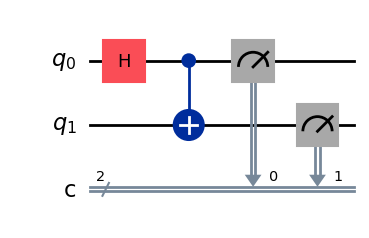


--- Procesando: Exp 1: Estado de Bell |Φ+> ---
Resultados (cuentas): {'11': 523, '00': 501}


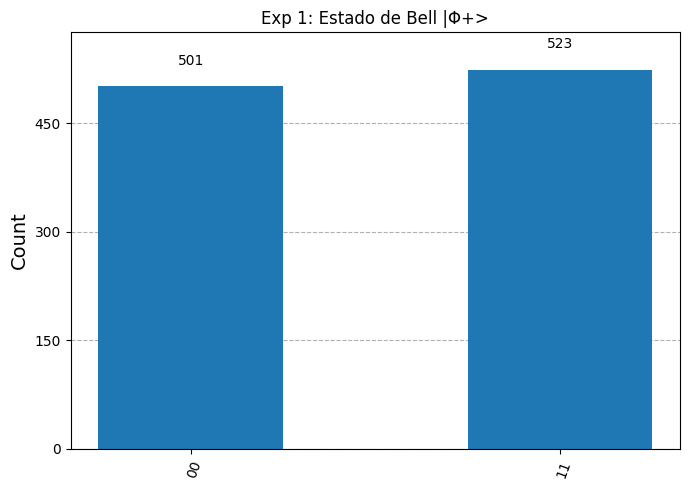

In [3]:
def experimento_1_bell():
    """Generación del estado máximamente entrelazado |Phi+>"""
    qc = QuantumCircuit(2, 2)
    
    # Creación del estado de superposición y entrelazamiento
    qc.h(0)      # Hadamard en q0 -> |+>
    qc.cx(0, 1)  # CNOT propaga el estado a q1
    
    # Colapso de la función de onda
    qc.measure([0, 1], [0, 1])
    
    return qc

qc1 = experimento_1_bell()
print("Circuito 1 generado.")
display(qc1.draw('mpl'))
conteos1 = ejecutar_y_graficar(qc1, "Exp 1: Estado de Bell |Φ+>")

## 2. Protocolo de Teleportación Cuántica
El objetivo es transferir el estado de un qubit $|\psi\rangle$ de Alice a Bob utilizando un par de Bell compartido como recurso.
* **Estado a teleportar:** $|1\rangle$
* **Validación:** Bob debe medir $|1\rangle$ con probabilidad del 100%.

Circuito 2 generado.


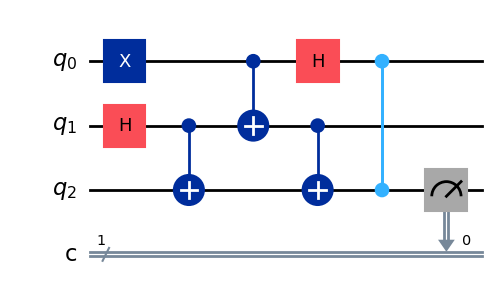


--- Procesando: Exp 2: Teleportación (Target |1>) ---
Resultados (cuentas): {'1': 1024}


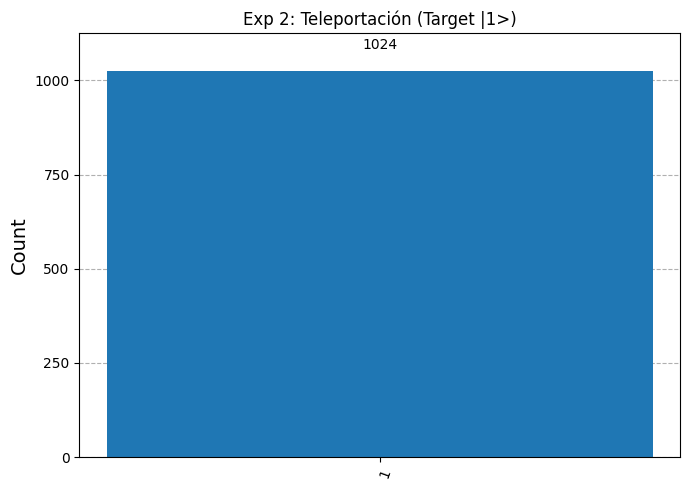

In [5]:
def experimento_2_teleportacion():
    """Transferencia de estado |psi> de Alice a Bob mediante recurso entrelazado"""
    
    # -- Subrutinas auxiliares --
    def create_bell_pair(qc, a, b):
        """ Recurso compartido entre Alice y Bob """
        qc.h(a)
        qc.cx(a, b)

    def alice_gates(qc, psi, a):
        """ Operaciones locales de Alice """
        qc.cx(psi, a)
        qc.h(psi)

    # Inicialización: 3 qubits (q0=Mensaje, q1=Alice, q2=Bob) + 1 bit clásico final
    qc = QuantumCircuit(3, 1) 

    # Paso 1: Generación del par EPR compartido
    create_bell_pair(qc, 1, 2)

    # Paso 2: Preparación del estado a teleportar (|psi> = |1>)
    qc.x(0) 

    # Paso 3: Procesamiento de Alice y envío de bits clásicos (implícito)
    alice_gates(qc, 0, 1)

    # Paso 4: Operaciones condicionales de Bob (Corrección del estado)
    # Nota: En simulador usamos puertas controladas cuánticas para emular el canal clásico
    qc.cx(1, 2) # Si Alice midió 1 en su qubit, Bob aplica X
    qc.cz(0, 2) # Si Alice midió 1 en psi, Bob aplica Z

    # Paso 5: Validación (Bob mide en la base Z)
    qc.measure(2, 0) 
    
    return qc

qc2 = experimento_2_teleportacion()
print("Circuito 2 generado.")
display(qc2.draw('mpl'))
conteos2 = ejecutar_y_graficar(qc2, "Exp 2: Teleportación (Target |1>)")

## 3. Transformada Cuántica de Fourier (QFT)
Implementación de la QFT para $N=3$ qubits. La QFT transforma un estado en la base computacional a la base de Fourier:
$$QFT|x\rangle = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} e^{2\pi i x k / 2^n} |k\rangle$$
Probaremos con el input $|100\rangle$ (decimal 4).

Circuito 3 generado.


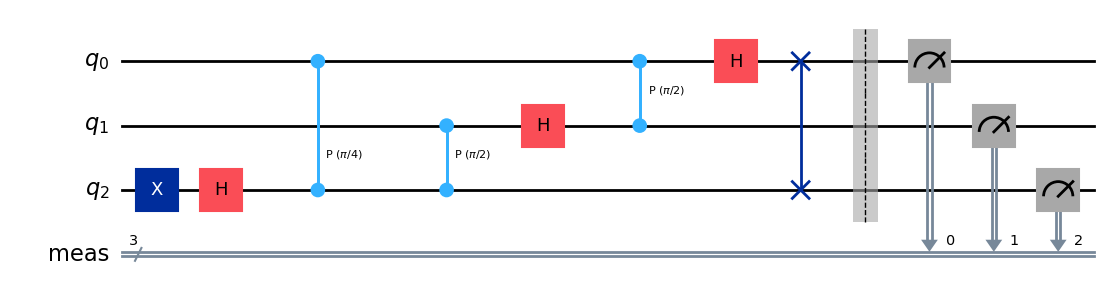


--- Procesando: Exp 3: QFT (Input |100>) ---
Resultados (cuentas): {'110': 126, '000': 116, '010': 124, '011': 120, '101': 136, '100': 141, '111': 119, '001': 142}


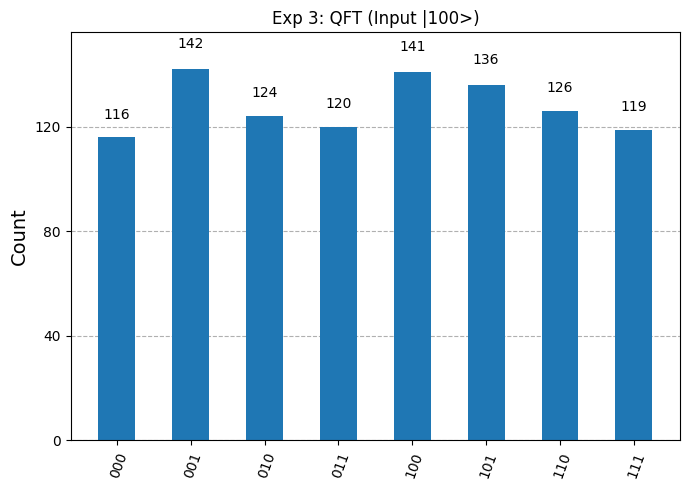

In [6]:
def experimento_3_qft():
    """Implementación de la QFT para N=3 qubits"""
    
    def qft_rotations(circuit, n):
        """ Aplicación recursiva de H y rotaciones de fase controladas (CP)"""
        if n == 0: return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            # Rotación R_k con ángulo pi / 2^k
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)

    def swap_registers(circuit, n):
        """ Inversión del orden de los qubits (necesario por la estructura de la QFT)"""
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit

    n_qubits = 3
    qc = QuantumCircuit(n_qubits)

    # Preparación del estado de entrada |100> (Decimal 4)
    # Nota: Qiskit usa orden Little Endian (q0 es el menos significativo)
    qc.x(2) 

    # Transformación a la base de Fourier
    qft_rotations(qc, n_qubits)
    swap_registers(qc, n_qubits)

    # Medición para observar la superposición uniforme en magnitud 
    qc.measure_all()
    
    return qc

qc3 = experimento_3_qft()
print("Circuito 3 generado.")
display(qc3.draw('mpl'))
conteos3 = ejecutar_y_graficar(qc3, "Exp 3: QFT (Input |100>)")

## 4. Estimación de Fase Cuántica (QPE)
Utilizamos el algoritmo QPE para estimar la fase $\theta$ de un operador unitario $U$ tal que $U|\psi\rangle = e^{2\pi i \theta}|\psi\rangle$.
* **Operador:** Puerta $T$
* **Fase teórica:** $\theta = 1/8 = 0.125$ (en binario $0.001$).

In [ ]:
def experimento_4_qpe():
    """Estimación de la autofase de la puerta T (theta = 1/8)"""
    
    def qft_inverse(circuit, n):
        """ QFT Dagger: Espejo de la QFT (Swaps + Rotaciones negativas) """
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        for j in range(n):
            for m in range(j):
                circuit.cp(-np.pi/float(2**(j-m)), m, j)
            circuit.h(j)

    n_counting = 3 # Precisión de 3 bits
    qc = QuantumCircuit(4, 3) 

    # 1. Superposición inicial en registro de conteo
    for qubit in range(n_counting):
        qc.h(qubit)
        
    # Preparación del autovector |1> para la puerta T
    qc.x(3) 

    # 2. Aplicación de controladas-U 
    # La fase esperada es 1/8 -> binario 0.001
    angle = np.pi / 4 # Fase intrínseca de T
    repetitions = 1
    for counting_qubit in range(n_counting):
        for i in range(repetitions):
            qc.cp(angle, counting_qubit, 3)
        repetitions *= 2

    # 3. Cambio de base (QFT Inversa) para leer la fase en la base computacional
    qft_inverse(qc, n_counting)

    # 4. Lectura del registro de conteo
    for n in range(n_counting):
        qc.measure(n, n)
        
    return qc

qc4 = experimento_4_qpe()
print("Circuito 4 generado.")
display(qc4.draw('mpl'))
conteos4 = ejecutar_y_graficar(qc4, "Exp 4: QPE (Fase Teórica: 0.001)")